# Fake News Detection

### Packages used

In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
%matplotlib inline
import time
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

import sklearn.metrics as skm #import confusion_matrix
import os
import re

In [4]:
# tests to see if gpu is working
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

with tf.Session() as sess:
    devices = sess.list_devices()
    print(devices)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 13375102977402078622), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16862762594651198801), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:1, XLA_GPU, 17179869184, 14776505528608291433), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 624207633021903897), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11273958196, 1149063495108294064), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 11273958196, 15259445200950350939)]
[[22. 28.]
 [49. 64.]]


In [5]:
data = pd.read_csv("FNC_Final.csv", engine="python", error_bad_lines= False)
data.head()

# examine summary stats for 'type' column

print(data.shape)
print(data['type'].describe())
print(data['type'].unique())

data['type'].fillna('unknown',inplace = True)
print(data['type'].describe())
print(data['type'].unique())

(142395, 27)
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']


In [6]:
# Remove articles from survey

survey_articles = pd.read_csv('survey_articles.csv')
survey_list = list(survey_articles['id'])
to_delete = list(data[data.id.isin(survey_list)].index)
data[data.id.isin(survey_list)]

# Remove articles from survey
data=data.drop(to_delete,axis=0)
data[data.id.isin(survey_list)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len


In [7]:
# examine reliable, satire, fake, etc. articles

reliable = data.loc[data['type'] == 'reliable']
satire = data.loc[data['type'] == 'satire']
fake = data.loc[data['type'] == 'fake']
political = data.loc[data['type'] == 'political']
bias = data.loc[data['type'] == 'bias']

print(type(reliable['type']))
print(len(reliable['type']))
print(type(fake['type']))
print(len(fake['type']))

print(len(satire['type']))
print(len(political['type']))
print(len(bias['type']))

<class 'pandas.core.series.Series'>
47753
<class 'pandas.core.series.Series'>
22280
2863
41166
28332


In [8]:
# select random sample from reliable, fake, etc, then combine in a new dataframe

fake = fake.sample(n=10000)
reliable = reliable.sample(n=10000)
satire = satire.sample (n=2863)
political = political.sample(n=10000)
bias = bias.sample(n=10000)
# print(type(fake))
# print(fake.head())

data = reliable.append(fake)
data = data.append(satire)
data = data.append(political)
data = data.append(bias)

# shuffle the new dataset
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len
0,152248,152248,703,7353652,beforeitsnews.com,fake,http://beforeitsnews.com/alternative/2016/03/p...,Police Reform Fight in Chicago Just Beginning ...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,...,NaN,NaN,62,14,0,5,['Police Reform Fight in Chicago Just Beginnin...,11,38,61.290323
1,159787,159787,2086,7726159,lifenews.com,bias,https://consciouslifenews.com/tag/okinawan-cen...,FAIR USE NOTICE. Many of the stories on this s...,2017-12-09T22:10:06.021376,2018-02-08 19:18:34.468038,...,NaN,NaN,242,4,0,12,"['FAIR USE NOTICE.', 'Many of the stories on t...",9,41,16.942149
2,172814,172814,9375,8297735,au.finance.yahoo.com,reliable,https://au.finance.yahoo.com/news/confidence-g...,"Tue, Nov 15, 2016, 4:08 AM AEDT - Australia Ma...",2016-11-14T19:12:09.467+02:00,2018-02-10 13:43:39.521661,...,NaN,webhose,212,7,0,7,"[""Tue, Nov 15, 2016, 4:08 AM AEDT - Australia ...",7,31,14.622642
3,77429,77429,5568,3624184,beforeitsnews.com,fake,http://beforeitsnews.com/politics/2015/02/indi...,(Before It's News)\n\nA 2006 government survey...,2017-11-21T12:56:35.440396,2018-02-07 23:39:33.852671,...,NaN,NaN,298,5,0,11,"[""(Before It's News)\n\nA 2006 government surv...",15,83,27.852349
4,196579,196579,5488,9244550,nytimes.com,reliable,https://www.nytimes.com/2009/05/31/style/tmaga...,3. Arrange the potatoes on a serving dish. Top...,2018-02-11 00:43:31.535705,2018-02-11 00:14:20.346838,...,NaN,nytimes,235,7,0,31,"['3.', 'Arrange the potatoes on a serving dish...",39,87,37.021277


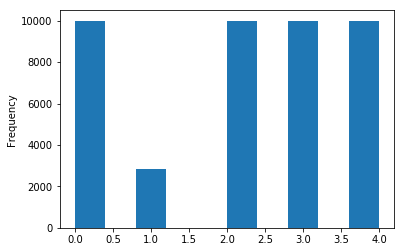

In [9]:
# change "reliable", "satire", "fake", etc. to 0,1,2,etc.

data.loc[data['type'] == 'reliable', 'type'] = 0.0
data.loc[data['type'] == 'political', 'type'] = 4.0
data.loc[data['type'] == 'bias', 'type'] = 3.0
data.loc[data['type'] == 'satire', 'type'] = 1.0
data.loc[data['type'] == 'fake', 'type'] = 2.0

data['content'] = data['title']+'\n'+data['content']
# plot the distribution,
data['type'].plot.hist()


In [10]:
# split data into train and test

msk = np.random.rand(len(data)) < 0.7

train = data[msk]
validation = data[~msk]

msk2 = np.random.rand(len(validation)) < 0.7

val = validation[msk2]
test = validation[~msk2]


train_data = train[['content','type']].copy()
val_data = val[['content','type']].copy()
test_data = test[['content','type']].copy()


print(len(train_data))
print(len(val_data))
print(len(test_data))

# print(train_data['type'])
# print(train_data['content'])

30014
9010
3839


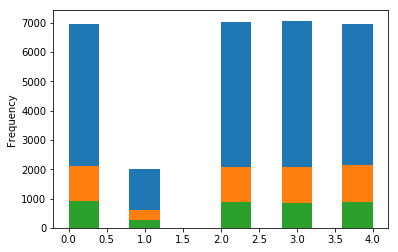

In [11]:
# plot the distribution of train_data
train_data['type'].plot.hist()

# plot the distribution of val_data
val_data['type'].plot.hist()

# plot the distribution of test_data
test_data['type'].plot.hist()

In [12]:
def cleanText(text):
    #remove EOL 
    text = str(text).strip().replace("\n", " ").replace("\r", " ")
#     text= text.split(" ")
    #remove stop words 
#     stops = set(stopwords.words("english"))
#     text = [w for w in text if not w in stops and len(w)>0]
    arr= text
    # preprocess data to standardize lengths
    #text= text[0:999]
        
    #text=' '.join(text)
    
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
    return arr

train_data["content"] = train_data["content"].apply(cleanText)
test_data["content"] = test_data["content"].apply(cleanText)
val_data["content"] = val_data["content"].apply(cleanText)

print(train_data["content"].head())

0    Police Reform Fight in Chicago Just Beginning ...
1    Okinawan centenarian study Archives FAIR USE N...
2    Confidence gauge to give view on Trump Tue, No...
4    Galician-style Lobster With Pimentón And Olive...
5    New Car Show & a Ferrari – FMV261 If Satan Is ...
Name: content, dtype: object


# Data preprocessing

In [13]:
DATA_COLUMN = 'content'
LABEL_COLUMN = 'type'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1, 2, 3, 4]

In [14]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_data.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_data.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test_data.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [15]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

W0805 14:37:04.037805 140334574135040 deprecation_wrapper.py:119] From /home/jupyter/src/FakeNews/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [16]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [17]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

W0805 14:37:10.580774 140334574135040 deprecation_wrapper.py:119] From /home/jupyter/src/FakeNews/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



# Creating a model
Now that we've prepared our data, let's focus on building a model. create_model does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our  task. This strategy of using a mostly trained model is called fine-tuning.

In [18]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs,
        signature="tokens",
        as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

In [19]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
              is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
#                 f1_score = tf.contrib.metrics.f1_score(
#                   label_ids,
#                   predicted_labels)
#                 auc = tf.metrics.auc(
#                   label_ids,
#                   predicted_labels)
#                 recall = tf.metrics.recall(
#                   label_ids,
#                   predicted_labels)
#                 precision = tf.metrics.precision(
#                   label_ids,
#                   predicted_labels) 
#                 true_pos = tf.metrics.true_positives(
#                   label_ids,
#                   predicted_labels)
#                 true_neg = tf.metrics.true_negatives(
#                   label_ids,
#                   predicted_labels)   
#                 false_pos = tf.metrics.false_positives(
#                   label_ids,
#                   predicted_labels)  
#                 false_neg = tf.metrics.false_negatives(
#                   label_ids,
#                   predicted_labels)
                return {
                  "eval_accuracy": accuracy,
#                   "f1_score": f1_score,
#                   "auc": auc,
#                   "precision": precision,
#                   "recall": recall,
#                   "true_positives": true_pos,
#                   "true_negatives": true_neg,
#                   "false_positives": false_pos,
#                   "false_negatives": false_neg
                  }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                  loss=loss,
                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                  loss=loss,
                  eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
              is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
              }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


In [20]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [21]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [22]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir='./model',
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [23]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


In [24]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [25]:
print('Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Training took time  0:00:00.009230


In [26]:
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [27]:
estimator.evaluate(input_fn=val_input_fn, steps=None)

W0805 14:44:26.057124 140334574135040 deprecation.py:506] From <ipython-input-18-4d5a7eab809a>:34: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0805 14:44:26.101669 140334574135040 deprecation_wrapper.py:119] From /home/jupyter/src/FakeNews/bert/optimization.py:27: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W0805 14:44:26.115610 140334574135040 deprecation_wrapper.py:119] From /home/jupyter/src/FakeNews/bert/optimization.py:32: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.

W0805 14:44:26.123687 140334574135040 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py:409: div (from tensor

{'eval_accuracy': 0.88690346, 'global_step': 2829, 'loss': 0.35353985}

In [30]:
preds = estimator.predict(input_fn= val_input_fn)
y_preds=[]
for y in preds:
    y_preds.append(y["labels"])
y_true=list(val_data['type'])

In [35]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
   # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")

    #print('')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = np.array(['reliable','satire','fake','bias','political'])


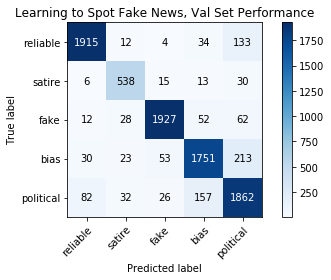

In [36]:
# Plot non-normalized confusion matrix
cm =skm.confusion_matrix(y_true,y_preds)
plot_confusion_matrix(cm, classes=class_names,normalize=False,
                      title='Learning to Spot Fake News, Val Set Performance')

# Run on Final Test Set

In [179]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [180]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'eval_accuracy': 0.8806981, 'global_step': 2829, 'loss': 0.37222502}

In [181]:
preds = estimator.predict(input_fn=test_input_fn)
y_preds=[]
for y in preds:
    y_preds.append(y["labels"])
y_true=list(test_data['type'])


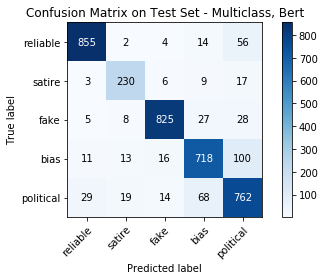

In [182]:
# Plot non-normalized confusion matrix

class_names = np.array(['reliable','satire','fake','bias','political'])
cm =skm.confusion_matrix(y_true,y_preds)
plot_confusion_matrix(cm, classes=class_names,normalize=False,
                      title='Confusion Matrix on Test Set - Multiclass, Bert')

In [166]:
rel_as_fake=[]
fake_as_rel=[]
sat_as_rel=[]
rel_as_sat=[]
fake_as_fake=[]
sat_as_sat=[]
for i in range(len(y_preds)):
    if y_preds[i]==2 and y_true[i]==0:
        rel_as_fake.append(i)
    elif y_preds[i]==0 and y_true[i]==2:
        fake_as_rel.append(i)
    elif y_preds[i]==1 and y_true[i]==0:
        rel_as_sat.append(i)
    elif y_preds[i]==0 and y_true[i]==1:
        sat_as_rel.append(i)
    elif y_preds[i]==2 and y_true[i]==2:
        fake_as_fake.append(i)
    elif y_preds[i]==1 and y_true[i]==1:
        sat_as_sat.append(i)

        
        
    

In [146]:
print('real as fake:',rel_as_fake)
print('fake as real:',fake_as_rel)
print('real as satire:',rel_as_sat)
print('satire as real:',sat_as_rel)
#print('fake as fake:',fake_as_fake)
#print('satire as satire:',sat_as_sat)

real as fake: [733, 867, 2266, 3441]
fake as real: [1674, 1836, 2094, 2779, 3834]
real as satire: [1069, 2529]
satire as real: [2142, 2476, 3177]


In [99]:
test_data_2=test_data.reset_index()



# Fake as Real

In [121]:
test_data_2.iloc[3834,:]['content']

'New Restaurant Gets Consult Last week, we took some friends to a new restaurant, ‘Steve’s Place,’ and noticed that the waiter who took our order carried a spoon in his shirt pocket.  It seemed a little strange. When the busboy brought our water and utensils, I observed that he also had a spoon in his shirt pocket.  Then I looked around and saw that all the staff had spoons in their pockets. When the waiter came back to serve our soup I inquired, ‘Why the spoon?’  ‘Well, ‘he explained, ‘the restaurant’s owner hired Andersen Consulting to revamp all of our processes. After several months of analysis, they concluded that the spoon was the most frequently dropped utensil. It represents a drop frequency of approximately 3 spoons per table per hour.  If our personnel are better prepared, we can reduce the number of trips back to the kitchen and save 15 man-hours per shift.’  As luck would have it, I dropped my spoon and he replaced it with his spare. ‘I’ll get another spoon next time I go t

In [110]:
test_data_2.iloc[1836,:]['content']

'Bill O’Brien says Texans have discussed signing Kaepernick - Boston.com “Is that a problem? Isn’t that the way most teams do it? People seem shocked by that.”'

# Fake as Fake

In [112]:
test_data_2.iloc[1925,:]['content']

'BREAKING: Trump Is Donating Entire Salary To Special Charity… President Trump has often said that he won’t take a dime of taxpayer money while he’s the commander-in-chief.  However, he’s legally required to take his yearly salary of $$400,000 — so he’s going to give it away.  The charity he’s donating to will be special, as White House Press Secretary Sean Spicer said that Trump has been gracious enough to let the media help decide where that money will go.  CNBC reports:  Trump had said during the campaign that he planned to donate his $$400,000 annual salary to charity.  Press Secretary Sean Spicer told journalists the president will give the money at the end of the year and would “love your help” to determine where it goes.  He said, “The way that we can avoid scrutiny is to let the press corps” help decide.  SHARE on Facebook and Twitter and let us know where you think he should donate to!  http://www.wedgies.com/question/should-trumps-department-of-justice-investigate-obamas-wire

# Real as Satire

In [106]:
test_data_2.iloc[1069,:]['content']

'France\'s Marine Le Pen: Trump Win Shows Power Slipping From \'Elites\' PARIS, France - The leader of France\'s far-right National Front party said Monday she believes Donald Trump\'s victory shows power is slipping from global "elites" who have "acted like carnivores" and "used the world to enrich only themselves. Marine Le Pen, who is running to be France\'s next president, told CNBC she is "very happy" about Trump\'s election and welcomed America\'s "courageous and advantageous" decision. "I think that the elites have lived too long among themselves. We are in a world where globalization, which is an ideology, has forgotten, and put aside the people, the people\'s interests, aspirations, and dreams," she said. CNBC: Trump Victory Shows Power is Slipping From Elites — Le Pen "They have acted like carnivores, who used the world to enrich only themselves, and whether it\'s the election of Donald Trump, or Brexit, the elites have realized that the people have stopped listening to them,

# Satire as Real

In [98]:
test_data_2.iloc[2476,:]['content']

"Post-Sept. 11 Changes In the wake of last month's terrorist attacks, a number of books, films, and other products have been altered or shelved. Among the changes:  In the wake of last month's terrorist attacks, a number of books, films, and other products have been altered or shelved. Among the changes:"

In [101]:
test_data_2.iloc[2142,:]['content']

"India vs Bangladesh T20 World Cup 2016: Star Sports live streaming info Tamim Iqbal's absence will affect Bangladesh's performance a lot when they play against India to keep their chances alive for T20 World Cup semi-final berth.  From now, the points matter the most, and the hosts will be trying hard to fetch some valuable points as they will lock horns with Bangladesh on a Super 10 encounter on Mar. 23, 2016, at the Chinnaswamy Stadium in Bangalore.  India will continue the lineup that won the first two matches.  Taskin Ahmed and Sunny will not be playing the game for Bangladesh, and it adds up salt to the wound. Another woo of skipper Mortaza is regarding the poor form of Soumya Sarkar.  In the midst of these problems, batsmen Rahman, Mahmudullah, and S Al Hasan will be leading the Tigers from the front.  Advertisements  Advertisements  Unlike previous times, the climate in Bangalore is much hot this year, and the temperature will inevitably cross 30 degree Celsius.  Bangaloreans c

In [102]:
test_data_2.iloc[3177,:]['content']

"Asia Cup 2016: Star Sports live streaming India vs Bangladesh 1st t20 Indian skipper MS Dhoni is doubtful for the first match of the Asia Cup 2016 against hosts Bangladesh. Dhoni suffered an onset of back spasms just two days ahead of the 1st t20 game.  The first game scheduled for Wednesday, February 24, 2016, will be played at Mirpur.  Parthiv Patel has been called in as backup wicket-keeper in case Dhoni is ruled out of the game.  It is still not clear if Patel will open the innings or bat in the middle-order if he gets a chance to play in the playing eleven.  The big match of the Asia Cup between arch rivals India and Pakistan is on Feb 27 in Dhaka. The Cricket live score and ball-by-ball commentary can be followed at Cricinfo or Cricbuzz.  Advertisements  Advertisements  The Indian selectors have sent a full-fledged squad for the Asia Cup as they cannot underestimate hosts Bangladesh at home, particularly after they won a series of games lately.  Weather forecast and pitch report

# Satire as Satire

In [120]:
test_data_2.iloc[2086,:]['content']

'GOP Bashes Minimum Wage, Backs ‘Black Teenage Unemployment Act’ WASHINGTON – Following the congressional winter break, the GOP has introduced its first major piece of legislation, which is aimed at increasing unemployment among black teenagers in America.  The National Economic Growth-Related Opportunities, Progression, Lengthened Employment And Social Equality Act (colloquially known as the “Negro Please” Act) came at the behest of former Reagan economic adviser Art Laffer, who recently said that the federal minimum wage is essentially the ‘the black teenage unemployment teenage act’.  “Once he said it out loud, a piece of legislation designed to make sure that black teenagers were legally prohibited from working just seemed to make sense,” said Rep. Paul Ryan (R-Wis.), who took a stance against the minimum wage last year. Laffer was arguing that the federal minimum wage means higher unemployment among black teenagers, which incorrectly assumes that the majority people on the minimum

## Binary Accuracy on Test Set 




Binary Accuracy:96.77


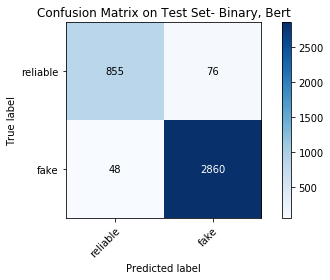

In [187]:
def binarize(x):
    if x in (1,2,3,4):
        x=1
    else:
        x=0
    return x

y_preds_bin =[binarize(x) for x in y_preds]
y_true_bin = [binarize(x) for x in y_true]

class_names = ['reliable','fake']

# Plot non-normalized confusion matrix
cm =skm.confusion_matrix(y_true_bin,y_preds_bin)
plot_confusion_matrix(cm, classes=class_names,normalize=False,
                      title='Confusion Matrix on Test Set- Binary, Bert')

bin_accuracy= skm.accuracy_score(y_true_bin,y_preds_bin)

print("Binary Accuracy:" + str((bin_accuracy*100).round(2)))

# Run Predictions on Survey Articles (for Comparison with Humans)

In [184]:
surveydata= pd.read_csv('survey_articles.csv')

surveydata.loc[surveydata['type'] == 'reliable', 'type'] = 0.0
surveydata.loc[surveydata['type'] == 'political', 'type'] = 4.0
surveydata.loc[surveydata['type'] == 'bias', 'type'] = 3.0
surveydata.loc[surveydata['type'] == 'satire', 'type'] = 1.0
surveydata.loc[surveydata['type'] == 'fake', 'type'] = 2.0

surveydata['content'] = surveydata['title']+'\n'+surveydata['content']
surveydata = surveydata[['content','type']].copy()

In [185]:
surveydata["content"] = surveydata["content"].apply(cleanText)

In [186]:
surveydata_Examples = surveydata.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

survey_features = bert.run_classifier.convert_examples_to_features(surveydata_Examples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [188]:
survey_input_fn = run_classifier.input_fn_builder(
    features=survey_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [189]:
estimator.evaluate(input_fn=survey_input_fn, steps=None)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'eval_accuracy': 0.47368422, 'global_step': 2829, 'loss': 1.5469476}

In [190]:
preds = estimator.predict(input_fn=survey_input_fn)
y_preds=[]
for y in preds:
    y_preds.append(y["labels"])
y_true=list(surveydata['type'])

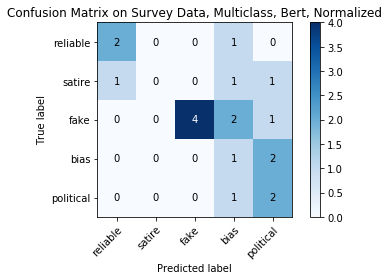

In [191]:
# Plot non-normalized confusion matrix
class_names = np.array(['reliable','satire','fake','bias','political'])
cm =skm.confusion_matrix(y_true,y_preds)
plot_confusion_matrix(cm, classes=class_names,normalize=False,
                      title='Confusion Matrix on Survey Data, Multiclass, Bert, Normalized')

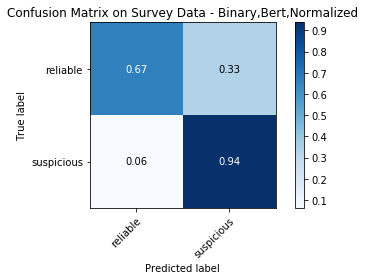

In [194]:
y_preds_bin =[binarize(x) for x in y_preds]
y_true_bin = [binarize(x) for x in y_true]
class_names = np.array(['reliable','suspicious'])
cm =skm.confusion_matrix(y_true_bin,y_preds_bin)
plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Confusion Matrix on Survey Data - Binary,Bert,Normalized')

## Run Predictions on Test Set (Final)

In [ ]:
def getPrediction(in_sentences):
    labels = [0, 1, 2, 3, 4]
    input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
    input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
print(val_data["content"].head())

In [ ]:
print(val_data["type"][2])
print(val_data["type"][4])
print(val_data["type"][6])
print(val_data["type"][8])
print(val_data["type"][17])

print(val_data["content"][2])
print(val_data["content"][4])
print(val_data["content"][6])
print(val_data["content"][8])
print(val_data["content"][17])

In [ ]:
# pred_sentences = [
#   "That movie was absolutely awful",
#   "The acting was a bit lacking",
#   "The film was creative and surprising",
#   "Absolutely fantastic!"
# ]

In [ ]:
pred_labels = [2, 3, 2, 2]
pred_sentences = [
    "BBC Guilty of Further Subliminal Advertising of Chemtrails at Wimbledon (Before It's News)  http://www.youtube.com/watch?v=a9LTvStFz0E  Published on 4 Jul 2013  It is not a new thing, for MSM and other entities to subliminally normalize the abnormal practice of chemtrail spraying, but rarely has it been so completely blatant as to feature in every single shot of the sky. Note that they even feature an aircraft spraying the material into the air at 0:18 and again in slow motion at 1:04.  Other examples of the normalization agenda can be viewed at:  http://www.youtube.com/watch?v=5Zx2pE…  The BBC are clearly complicit with the ‘hidden in plain sight’ Chemtrail agenda. They do not cover it in their news, they speak occasionally of Geoengineering as if it is a matter that may be needed in the future, but they bombard you with their images of it constantly and especially within children’s programmes and films. Question why that would be.  TV Ark is an excellent website whereby you can look at past Wimbledon opening credits from 1981 to 2010. There it is clear to see that they have decided to include subliminal Chemtrail images only this year:  http://www2.tv-ark.org.uk/sport/bbc_w…  You Tube Video of past opening credits from 2007:  http://www.youtube.com/watch?v=m6bWTT…  Other subliminal Chemtrail images that have been exposed:  http://www.chemtrailplanet.com/Sublim…  http://www.chemtrailplanet.com/MCDB.htm  For Educational Purposes Only. Claim “fair use” in copyright under Section 107 of the copyright act 1976.",
    "Defend Democracy Press by James Petras Introduction: Eight months will have passed since the election of Syriza on January 25 up to the snap elections in September. During that...",
    "Work Days Are Here Again Work Days Are Here Again  (Before It's News)  It’s spring, and I know people want to get their hands dirty. I know my hands are dirty. So, how about these days for volunteer days:  March 29 (Yes, this Saturday), 10am-2pm  April 19, 10am-2pm  May 10, 10am-2pm  Right at 10, I’ll do a little tour, then we’ll get down to work. This Saturday will be a tomato planting day, and I’ll have starts to give away to volunteers. April 19 will be a bed prepping day, and I’ll do a worm composting demonstration. I might have some yummy snacks, too.  Garden is at 2727 Martin Luther King Jr Way, at 28th Street. Entrance is on 28th Street. Bring gloves, water, sun hats.  Also, there’s only one person signed up for the chicken class. It’s on April 26, and will be lots of fun. If you want to sign up, email me at novellacarpenter at gmail.  Source: https://ghosttownfarm.wordpress.com/2014/03/25/work-days-are-here-again/",
    "US orders embassy workers out of Beirut ahead of possible Syria strike US orders embassy workers out of Beirut ahead of possible Syria strike  % of readers think this story is Fact. Add your two cents.  (Before It's News)  The United States has withdrawn all non-emergency embassy workers and their families from Beirut and warned Americans against travel to Lebanon amid looming military strikes on Syria, the State Department said Friday.  Read more >>"
]

In [ ]:
predictions = getPrediction(pred_sentences)

In [ ]:
predictions

# Test on Survey Articles

In [ ]:
data2 = pd.read_csv("FNC_Final.csv", engine="python", error_bad_lines= False)
data2.head()

In [ ]:
print(len(data2[data2.id.isin(survey_list)]['content']))
print(data2[data2.id.isin(survey_list)]['content'])

In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)